##### HW 4, Part 2, Start
### CSCI 4270 and 6270, Spring 2025

This is starter code for HW 4, Part 2. Most important is the definition of the Dataset object for loading, separately, the train, validation and test image sets. Students can use as much or as little of this as they wish and can modify it in anyway they'd like

In [29]:
import numpy as np
import os 
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
def is_image(fn):
    extensions = ['.jpg', '.jpeg', '.png']
    return any(fn.lower().endswith(ext) for ext in extensions)

def find_images_in_folder(folder_path, verbose=False):
    full_image_paths = []
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is an image
        if os.path.isfile(file_path) and is_image(filename):
            # Try opening the image
            try:
                im = Image.open(file_path)
                full_image_paths.append(file_path)
                if verbose:
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")
    print(f'Returing {len(full_image_paths)} image paths')
    return full_image_paths

folder_path = "hw4_data/valid/ocean"
full_paths = find_images_in_folder(folder_path, verbose=False)


Returing 150 image paths


In [31]:
'''
Provide a Dataset object for the five class dataset.
'''

# These are empirically determined values to optimize image intensity rescaling prior to training
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

'''
The Dataset class we write must include the __init__, __len__ and __getitem__ (subscripting) 
methods.
'''
class HW4_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        '''
        Produce a list of the full image paths and class indices for all images
        in the given set (found along the path).  Record a transform to be
        applied by the __getitem__ method to each image.
        '''
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []
        for idx, nm in enumerate(class_names):
            folder_path = os.path.join(path, nm)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([transforms.Resize(new_size),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])
        else:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        fp = self.full_image_paths[idx]
        class_i = self.gt_class_idx[idx]
        im = Image.open(fp)
        im = self.transform(im)
        return im, class_i
        
        
class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# new_size = 60   # This reduces the original 240x360 images to 60x90.  Setting it to 240 leaves the images unchanged
new_size = None # Setting new_size to None keeps the original image size.
verbose = False

# Form all three datasets.
train_dataset = HW4_Dataset("hw4_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = HW4_Dataset("hw4_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset = HW4_Dataset("hw4_data/test", class_names, new_size=new_size, verbose=verbose)


Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths


The validation dataset has 750 images
After the shuffle the 0th image has class index 2
Image shape is (240, 360, 3)


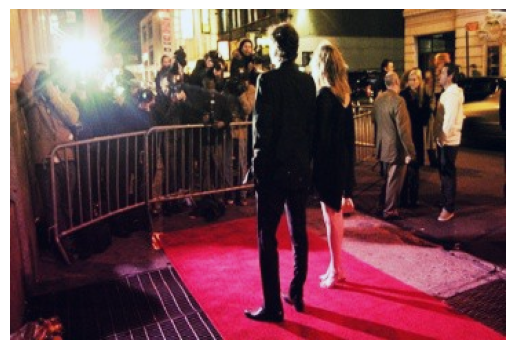

2


In [32]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(valid_dataset)
print(f'The validation dataset has {n} images')

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

# Get the image and the class id of the 0th image after the shuffle.
im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.show()
print(class_idx)

In [33]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
from torch import nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#CNN model
class SceneClassifier(nn.Module):
    def __init__(self, num_classes=5, new_size=(60,90)):
        super(SceneClassifier, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        if new_size is None:
            #assuming a default size based on randomly selected images
            new_size = (240, 360)
            
        dummy_input = torch.zeros(1, 3, new_size[0], new_size[1])
        dummy_out = self.conv_stack(dummy_input)
        flattened_size = dummy_out.numel()
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_stack(x)
        logits = self.fc_stack(x)
        return logits

#choose the SceneClassifier model.
model = SceneClassifier(num_classes=len(class_names), new_size=new_size).to(device)
print(model)
for p in model.parameters():
    print(p.size())

Using cpu device
SceneClassifier(
  (conv_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=172800, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)
torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([128, 172800])
torch.Size([128])
torch.Size([5, 128])
torch.Size([5])


In [ ]:
if new_size:
    mb = torch.rand(batch_size, 3, new_size[0], new_size[1]).to(device)
else:
    mb = torch.rand(batch_size, 3, 240, 360).to(device)
logits = model(mb)
print("Output logits size:", logits.size())

#define loss function and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

Output logits size: torch.Size([32, 5])


New Best Model Found: Epoch 1 | Train Loss: 1.6052, Val Acc: 0.2693
New Best Model Found: Epoch 2 | Train Loss: 1.5898, Val Acc: 0.4213
New Best Model Found: Epoch 3 | Train Loss: 1.5755, Val Acc: 0.4947
New Best Model Found: Epoch 4 | Train Loss: 1.5605, Val Acc: 0.5173
New Best Model Found: Epoch 5 | Train Loss: 1.5441, Val Acc: 0.5280
New Best Model Found: Epoch 6 | Train Loss: 1.5271, Val Acc: 0.5347
New Best Model Found: Epoch 7 | Train Loss: 1.5080, Val Acc: 0.5387
New Best Model Found: Epoch 8 | Train Loss: 1.4867, Val Acc: 0.5507
New Best Model Found: Epoch 9 | Train Loss: 1.4645, Val Acc: 0.5587
New Best Model Found: Epoch 10 | Train Loss: 1.4405, Val Acc: 0.5667
New Best Model Found: Epoch 12 | Train Loss: 1.3871, Val Acc: 0.5840
New Best Model Found: Epoch 13 | Train Loss: 1.3603, Val Acc: 0.5853
New Best Model Found: Epoch 14 | Train Loss: 1.3321, Val Acc: 0.5920
New Best Model Found: Epoch 15 | Train Loss: 1.3037, Val Acc: 0.6053
New Best Model Found: Epoch 16 | Train Loss

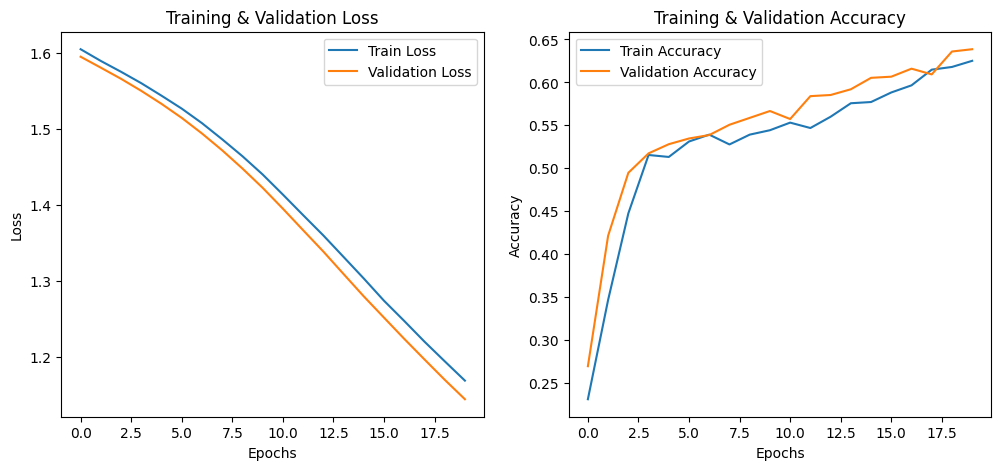

Final Test Accuracy: 59.33%


In [ ]:
def train_and_validate(train_loader, val_loader, model, loss_fn, optimizer, epochs=20):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (pred.argmax(1) == y).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)

        #validation phase
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()
                val_correct += (pred.argmax(1) == y).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        #save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New Best Model Found: Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

history = train_and_validate(train_loader, valid_loader, model, loss_fn, optimizer, epochs=20)
#plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.show()

#test best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        correct += (pred.argmax(1) == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

#iterate over the test set and collect predictions
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

#overall accuracy
total_samples = len(all_labels)
correct_preds = np.sum(all_preds == all_labels)
overall_accuracy = 100 * correct_preds / total_samples
print(f"Final Test Accuracy: {overall_accuracy:.2f}%")

#confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)



Final Test Accuracy: 59.33%
Confusion Matrix:
[[ 69   7  29  27  18]
 [ 16  98   5  17  14]
 [  4   1 122  11  12]
 [ 16  14  15  97   8]
 [ 17  12  53   9  59]]


**Summary**

I chose a convolutional neural network (CNN) with several convolutional layers followed by a single fully-connected layer that was used in the class example. There were two convolutional blocks used, each with a ReLU activation and a max pooling layer. After flattening the output of the convolutional layers, one dense layer was used to map features to the final output classes, the fully-connected layer. The final test accuracy was 59.33% which is relatively low, however I reduced the number of epochs that were undergone during the training process to save time. Because of this low number of iterations(20), it is highly likely that the model did not have time to fully learn. This is seen in the fact that the new best model was continuing to be replaced upto and even at the 20th epoch suggesting a higher epoch with a self stopping mechanism would increase the validation accuracy and even the final test accuracy.